# *ACL-Fantasy*

# **Libraries import**

**pandas:** the first library we learned, used for loading and handling datasets.

**numpy:** helps with math operations and working with arrays.

**tensorflow / keras:** used to build and train our neural network model.

**train_test_split:** splits the data into training and testing sets.

**StandardScaler:** prepares the data by scaling the features for better model performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import shap
import lime
import lime.lime_tabular

2025-10-19 21:07:09.518760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760908029.744393      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760908029.807090      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Load and Explore FPL Data**

Let's load the Fantasy Premier League dataset containing player statistics across multiple seasons.

In [2]:
# Load the FPL dataset from a local CSV file
# df = pd.read_csv('cleaned_merged_seasons.csv')
# Load the FPL dataset from Kaggle
df = pd.read_csv('/kaggle/input/fantasy-football/cleaned_merged_seasons.csv', low_memory=False)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset shape: (96169, 37)

Columns: ['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW']

Data types:
season_x              object
name                  object
position              object
team_x                object
assists                int64
bonus                  int64
bps                    int64
clean_sheets           int64
creativity           float64
element                int64
fixture                int64
goals_conceded         int64
goals_scored           int64
ict_index            float64
influence            float64
kickoff_time          

# **Data Preprocessing and Feature Engineering**


In [3]:
df.head(10)

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,1.0,0.0,1,0,0,0,45,True,1,1
5,2016-17,Adam Lallana,MID,NaN,1,2,33,0,33.7,205,...,3.0,57.0,11,0,0,0,70,False,1,1
6,2016-17,Adam Smith,DEF,NaN,0,0,23,0,4.3,34,...,1.0,27.0,7,0,0,0,45,True,0,1
7,2016-17,Adrián San Miguel del Castillo,GK,NaN,0,0,16,0,0.0,450,...,2.0,0.0,2,0,0,0,50,False,0,1
8,2016-17,Alex Iwobi,MID,NaN,1,0,12,0,17.5,21,...,3.0,0.0,3,0,0,0,60,True,1,1
9,2016-17,Alex McCarthy,GK,NaN,0,0,0,0,0.0,101,...,1.0,0.0,0,0,0,0,45,True,0,1


## **Data Cleaning**

In [4]:
# Create a copy of the dataframe
df_clean = df.copy()

df_clean = df_clean.drop(columns=['team_x','team_a_score','team_h_score','round','kickoff_time','threat','creativity','influence','transfers_balance','transfers_in','transfers_out'])

# # Remove rows where player didn't play (minutes = 0)
# df_clean = df_clean[df_clean['minutes'] > 0]

# # Handle missing values
# df_clean = df_clean.fillna(0)

# Encode categorical variables
# Position encoding
df_clean['position'] = df_clean['position'].map({'GK': 0,'GKP': 0, 'DEF': 1, 'MID': 2, 'FWD' : 3})
# Was_home: already boolean, convert to int
df_clean['was_home'] = df_clean['was_home'].astype(int)

# Check missing values
df_clean.isna().sum().sort_values(ascending=False).head(37)

print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Missing values after cleaning:\n{df_clean.isnull().sum().sum()}")

Cleaned dataset shape: (96169, 26)
Missing values after cleaning:
0


Let's take a look at the data after applying the preprocessing techniques

In [5]:
df_clean.head()

,season_x,name,position,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,...,penalties_missed,penalties_saved,red_cards,saves,selected,total_points,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,1,0,0,0,0,454,10,0,...,0,0,0,0,14023,0,55,0,0,1
1,2016-17,Aaron Lennon,2,0,0,6,0,142,3,0,...,0,0,0,0,13918,1,60,1,0,1
2,2016-17,Aaron Ramsey,2,0,0,5,0,16,8,3,...,0,0,0,0,163170,2,80,1,0,1
3,2016-17,Abdoulaye Doucouré,2,0,0,0,0,482,7,0,...,0,0,0,0,1051,0,50,0,0,1
4,2016-17,Adam Forshaw,2,0,0,3,0,286,6,1,...,0,0,0,0,2723,1,45,1,1,1


In [6]:
df_clean['was_home'].value_counts()

was_home
0    48105
1    48064
Name: count, dtype: int64

In [7]:
df_clean['position'].value_counts()

position
2    39163
1    33683
3    12669
0    10654
Name: count, dtype: int64

In [34]:

ORDER_COL = "GW" if "GW" in df_clean.columns else "round"

def _form_last4(g: pd.DataFrame) -> pd.Series:
    ordered = g.sort_values(ORDER_COL)
    feat = ordered["total_points"].shift(1).rolling(window=4, min_periods=1).mean() / 10.0
    return feat.reindex(g.index)  # align back to the group's original order

df_clean["form"] = (
   df_clean.groupby(["season_x", "element"], sort=False, group_keys=False)
      .apply(_form_last4)
)
first_row_mask = df_clean.groupby(["season_x","element"]).cumcount() == 0
df_clean.loc[first_row_mask, "form"] = 0.0
df_clean.head(10)


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,season_x,name,position,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,...,penalties_saved,red_cards,saves,selected,total_points,value,was_home,yellow_cards,GW,form
19852,2020-21,Aaron Connolly,3,0,0,-3,0,78,7,2,...,0,0,0,32205,1,55,1,0,1,0.000000
20277,2020-21,Aaron Connolly,3,0,2,27,1,78,16,0,...,0,0,0,35030,8,55,0,0,2,0.100000
20816,2020-21,Aaron Connolly,3,0,0,2,0,78,19,2,...,0,0,0,55356,2,55,1,0,3,0.450000
21370,2020-21,Aaron Connolly,3,0,0,7,0,78,32,3,...,0,0,0,55125,2,55,0,0,4,0.366667
21932,2020-21,Aaron Connolly,3,1,0,13,0,78,40,0,...,0,0,0,46774,4,55,0,0,5,0.325000
22519,2020-21,Aaron Connolly,3,0,0,0,0,78,51,0,...,0,0,0,50818,0,55,1,0,6,0.400000
23109,2020-21,Aaron Connolly,3,0,0,0,0,78,67,0,...,0,0,0,43547,0,55,0,0,7,0.200000
23706,2020-21,Aaron Connolly,3,0,0,3,0,78,70,0,...,0,0,0,39808,1,54,1,0,8,0.150000
24306,2020-21,Aaron Connolly,3,0,0,0,0,78,79,0,...,0,0,0,33468,0,54,0,0,9,0.125000
24907,2020-21,Aaron Connolly,3,0,0,0,0,78,90,1,...,0,0,0,31760,2,53,1,0,10,0.025000


In [38]:
df_clean["season_x"].unique()


array(['2020-21', '2021-22', '2016-17', '2017-18', '2022-23'],
      dtype=object)

In [35]:
df_clean.columns


Index(['season_x', 'name', 'position', 'assists', 'bonus', 'bps',
       'clean_sheets', 'element', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'opponent_team', 'opp_team_name', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'selected',
       'total_points', 'value', 'was_home', 'yellow_cards', 'GW', 'form'],
      dtype='object')

Average total points per season by position:
   position  total_points
0         2       11384.4
1         1        8705.2
2         3        3975.8
3         0        2463.2


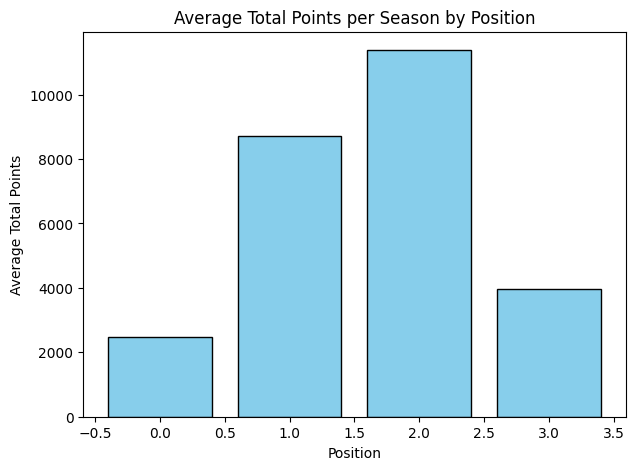

In [36]:
import matplotlib.pyplot as plt

# --- group by season and position ---
pos_season_points = (
    df_clean.groupby(["season_x", "position"])["total_points"]
      .sum()
      .reset_index()
)

# --- compute the average total points per season for each position ---
avg_points = (
    pos_season_points.groupby("position")["total_points"]
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

# --- print results ---
print("Average total points per season by position:")
print(avg_points)

# --- visualize ---
plt.figure(figsize=(7,5))
plt.bar(avg_points["position"], avg_points["total_points"], color="skyblue", edgecolor="black")
plt.title("Average Total Points per Season by Position")
plt.ylabel("Average Total Points")
plt.xlabel("Position")
plt.show()


In [9]:
# Compute form = avg total_points over last 4 gameweeks / 10
df_clean = df_clean.sort_values(['name', 'season_x', 'GW'])

def calculate_form(group):
    group = group.sort_values('GW')
    group['form'] = group['total_points'].shift(1).rolling(window=4, min_periods=1).mean() / 10
    return group.fillna({'form': 0})

df_clean = df_clean.groupby(['name', 'season_x',"element"], group_keys=False).apply(calculate_form)

df_clean.head(10)


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,season_x,name,position,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,...,penalties_saved,red_cards,saves,selected,total_points,value,was_home,yellow_cards,GW,form
19852,2020-21,Aaron Connolly,3,0,0,-3,0,78,7,2,...,0,0,0,32205,1,55,1,0,1,0.000000
20277,2020-21,Aaron Connolly,3,0,2,27,1,78,16,0,...,0,0,0,35030,8,55,0,0,2,0.100000
20816,2020-21,Aaron Connolly,3,0,0,2,0,78,19,2,...,0,0,0,55356,2,55,1,0,3,0.450000
21370,2020-21,Aaron Connolly,3,0,0,7,0,78,32,3,...,0,0,0,55125,2,55,0,0,4,0.366667
21932,2020-21,Aaron Connolly,3,1,0,13,0,78,40,0,...,0,0,0,46774,4,55,0,0,5,0.325000
22519,2020-21,Aaron Connolly,3,0,0,0,0,78,51,0,...,0,0,0,50818,0,55,1,0,6,0.400000
23109,2020-21,Aaron Connolly,3,0,0,0,0,78,67,0,...,0,0,0,43547,0,55,0,0,7,0.200000
23706,2020-21,Aaron Connolly,3,0,0,3,0,78,70,0,...,0,0,0,39808,1,54,1,0,8,0.150000
24306,2020-21,Aaron Connolly,3,0,0,0,0,78,79,0,...,0,0,0,33468,0,54,0,0,9,0.125000
24907,2020-21,Aaron Connolly,3,0,0,0,0,78,90,1,...,0,0,0,31760,2,53,1,0,10,0.025000


Top 5 players in 2022-23
   element             name  total_points
0      318   Erling Haaland           272
1      427       Harry Kane           263
2      283    Mohamed Salah           239
3        7  Martin Ødegaard           212
4      335  Marcus Rashford           205


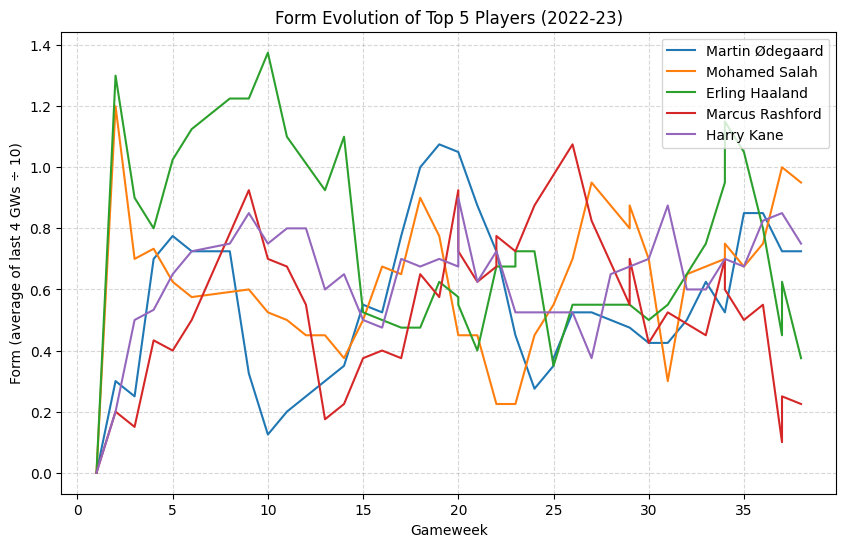

In [45]:
season = "2022-23"   # match your dataset’s exact label

# --- filter only that season ---
df_22 = df_clean[df_clean["season_x"] == season].copy()

# --- find top 5 players by total points in that season ---
top5_players = (
    df_22.groupby(["element", "name"])["total_points"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

print("Top 5 players in", season)
print(top5_players)

# --- keep only those players for plotting ---
df_top5 = df_22[df_22["element"].isin(top5_players["element"])]

# --- plot form evolution ---
plt.figure(figsize=(10,6))
for pid, player_data in df_top5.groupby("element"):
    plt.plot(player_data["GW"], player_data["form"], label=player_data["name"].iloc[0])

plt.title(f"Form Evolution of Top 5 Players ({season})")
plt.xlabel("Gameweek")
plt.ylabel("Form (average of last 4 GWs ÷ 10)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [44]:
# show all unique season names (and their lengths)
for s in df_clean["season_x"].unique():
    print(repr(s), "→ length:", len(s))


'2020-21' → length: 7
'2021-22' → length: 7
'2016-17' → length: 7
'2017-18' → length: 7
'2022-23' → length: 7


In [10]:
df_clean[df_clean['season_x'] == '2016-17'].head(10)

,season_x,name,position,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,...,penalties_saved,red_cards,saves,selected,total_points,value,was_home,yellow_cards,GW,form
0,2016-17,Aaron Cresswell,1,0,0,0,0,454,10,0,...,0,0,0,14023,0,55,0,0,1,0.00
2404,2016-17,Aaron Cresswell,1,0,0,0,0,454,20,0,...,0,0,0,11531,0,55,1,0,2,0.00
4739,2016-17,Aaron Cresswell,1,0,0,0,0,454,29,0,...,0,0,0,9587,0,54,0,0,3,0.00
7285,2016-17,Aaron Cresswell,1,0,0,0,0,454,38,0,...,0,0,0,8427,0,54,1,0,4,0.00
7498,2016-17,Aaron Cresswell,1,0,0,0,0,454,46,0,...,0,0,0,7933,0,54,0,0,5,0.00
7711,2016-17,Aaron Cresswell,1,0,0,0,0,454,59,0,...,0,0,0,7450,0,54,1,0,6,0.00
7924,2016-17,Aaron Cresswell,1,0,0,0,0,454,70,0,...,0,0,0,7199,0,53,1,0,7,0.00
8137,2016-17,Aaron Cresswell,1,1,0,23,1,454,74,0,...,0,1,0,7862,6,53,0,0,8,0.00
8351,2016-17,Aaron Cresswell,1,0,0,0,0,454,90,0,...,0,0,0,9957,0,53,1,0,9,0.15
195,2016-17,Aaron Cresswell,1,0,0,12,0,454,92,2,...,0,0,0,12638,1,53,0,0,10,0.15


In [11]:
#check a specific player:
df_clean[df_clean['name'] == 'Harry Kane'].sort_values(['season_x', 'GW']).head(15)

,season_x,name,position,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,...,penalties_saved,red_cards,saves,selected,total_points,value,was_home,yellow_cards,GW,form
70,2016-17,Harry Kane,3,0,0,5,0,403,3,1,...,0,0,0,618838,2,110,0,0,1,0.000
2475,2016-17,Harry Kane,3,1,0,19,1,403,16,0,...,0,0,0,629934,5,110,1,0,2,0.200
4811,2016-17,Harry Kane,3,0,0,2,0,403,27,1,...,0,0,0,516298,2,109,1,0,3,0.350
7361,2016-17,Harry Kane,3,0,0,28,1,403,37,0,...,0,0,0,534669,6,109,0,0,4,0.300
7574,2016-17,Harry Kane,3,0,3,38,1,403,49,0,...,0,0,0,560764,9,109,1,0,5,0.375
7787,2016-17,Harry Kane,3,0,0,0,0,403,55,0,...,0,0,0,303986,0,108,0,0,6,0.550
8000,2016-17,Harry Kane,3,0,0,0,0,403,68,0,...,0,0,0,241634,0,108,1,0,7,0.425
8214,2016-17,Harry Kane,3,0,0,0,0,403,80,0,...,0,0,0,217982,0,107,0,0,8,0.375
8429,2016-17,Harry Kane,3,0,0,0,0,403,82,0,...,0,0,0,209454,0,107,0,0,9,0.225
275,2016-17,Harry Kane,3,0,0,0,0,403,98,0,...,0,0,0,204091,0,107,1,0,10,0.000


In [12]:
#verify order of all seasons:
df_clean[['season_x', 'name', 'GW', 'form']].sort_values(['season_x', 'name', 'GW']).head(11120)

,season_x,name,GW,form
0,2016-17,Aaron Cresswell,1,0.0
2404,2016-17,Aaron Cresswell,2,0.0
4739,2016-17,Aaron Cresswell,3,0.0
7285,2016-17,Aaron Cresswell,4,0.0
7498,2016-17,Aaron Cresswell,5,0.0
...,...,...,...,...
9188,2017-18,Daniel Amartey,11,0.0
9477,2017-18,Daniel Amartey,12,0.0
9767,2017-18,Daniel Amartey,13,0.0
10057,2017-18,Daniel Amartey,14,0.0


,season_x,first_gameweek,last_gameweek,n_players,total_rows
0,2016-17,1,38,243,8567
1,2017-18,1,38,315,11285
2,2020-21,1,38,712,24365
3,2021-22,1,38,735,25447
4,2022-23,1,38,777,26505


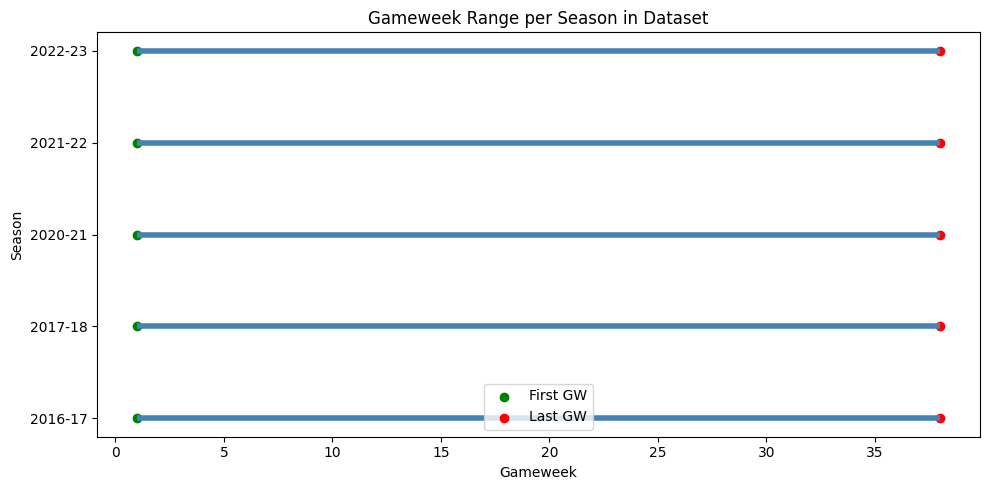

In [13]:
#Verify all seasons and gameweeks

# Create a summary per season
season_summary = (
    df_clean.groupby('season_x')
      .agg(first_gameweek=('GW', 'min'),
           last_gameweek=('GW', 'max'),
           n_players=('name', 'nunique'),
           total_rows=('name', 'count'))
      .reset_index()
      .sort_values('season_x')
)

# Display summary table
display(season_summary)

# Plot to visualize range of gameweeks per season
plt.figure(figsize=(10, 5))
plt.hlines(y=season_summary['season_x'],
           xmin=season_summary['first_gameweek'],
           xmax=season_summary['last_gameweek'],
           color='steelblue', linewidth=4)
plt.scatter(season_summary['first_gameweek'], season_summary['season_x'], color='green', label='First GW')
plt.scatter(season_summary['last_gameweek'], season_summary['season_x'], color='red', label='Last GW')
plt.xlabel('Gameweek')
plt.ylabel('Season')
plt.title('Gameweek Range per Season in Dataset')
plt.legend()
plt.tight_layout()
plt.show()


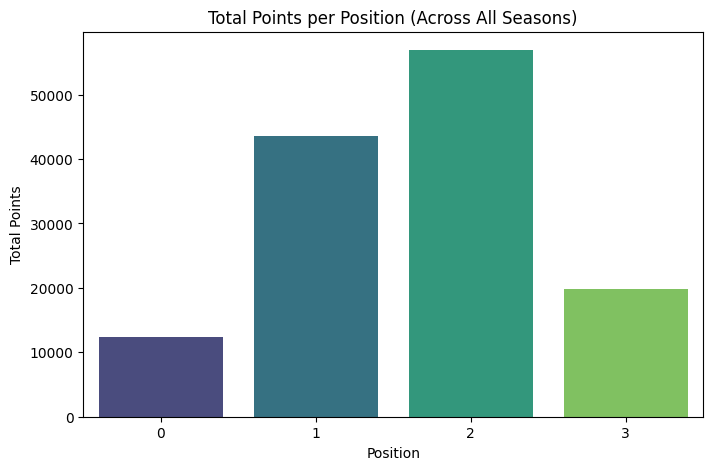

,position,total_points
2,2,56922
1,1,43526
3,3,19879
0,0,12316


In [14]:
# Sum total points per position per season
pos_points = df_clean.groupby(['season_x', 'position'], as_index=False)['total_points'].sum()

#Total points per position (combined across all seasons)
total_pos_points = (
    df_clean.groupby('position', as_index=False)['total_points']
    .sum()
    .sort_values('total_points', ascending=False)
)
plt.figure(figsize=(8,5))
sns.barplot(x='position', y='total_points', data=total_pos_points, palette='viridis')
plt.title('Total Points per Position (Across All Seasons)')
plt.xlabel('Position')
plt.ylabel('Total Points')
plt.show()

total_pos_points

# **Which positions score most on average**

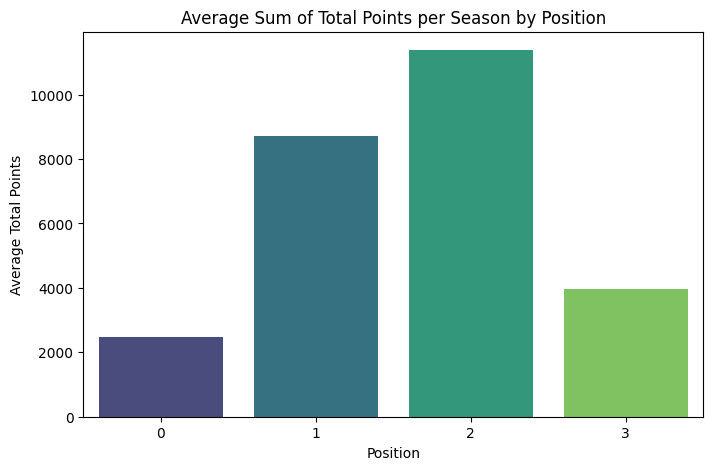

,position,total_points
2,2,11384.4
1,1,8705.2
3,3,3975.8
0,0,2463.2


In [15]:
# Sum total points per position per season
pos_points = df_clean.groupby(['season_x', 'position'], as_index=False)['total_points'].sum()

# Average across seasons
avg_pos_points = pos_points.groupby('position', as_index=False)['total_points'].mean().sort_values('total_points', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='position', y='total_points', data=avg_pos_points, palette='viridis')
plt.title('Average Sum of Total Points per Season by Position')
plt.xlabel('Position')
plt.ylabel('Average Total Points')
plt.show()

avg_pos_points

# **Top 5 player form in 2022–23 season**

In [16]:
# Filter for 2022–23 season
season_22 = df_clean[df_clean['season_x'].astype(str).str.contains("2022")]

# Average form and total points per player
player_stats = season_22.groupby('name', as_index=False).agg({
    'form': 'mean',
    'total_points': 'sum'
})

# Top 5 by form and total points
top5_form = player_stats.nlargest(5, 'form')
top5_points = player_stats.nlargest(5, 'total_points')

print("Top 5 by form:")
display(top5_form)
print("\nTop 5 by total points:")
display(top5_points)

# Compare overlap
overlap = set(top5_form['name']).intersection(set(top5_points['name']))
print("\nOverlap between top 5 by form and total points:", overlap)


Top 5 by form:


,name,form,total_points
210,Erling Haaland,0.745395,272
256,Harry Kane,0.635746,263
540,Mohamed Salah,0.621272,239
498,Martin Ødegaard,0.550658,212
236,Gabriel Martinelli Silva,0.546930,198



Top 5 by total points:


,name,form,total_points
210,Erling Haaland,0.745395,272
256,Harry Kane,0.635746,263
540,Mohamed Salah,0.621272,239
498,Martin Ødegaard,0.550658,212
490,Marcus Rashford,0.533772,205



Overlap between top 5 by form and total points: {'Harry Kane', 'Erling Haaland', 'Martin Ødegaard', 'Mohamed Salah'}


# **Visualize top 5 form evolution across gameweeks**

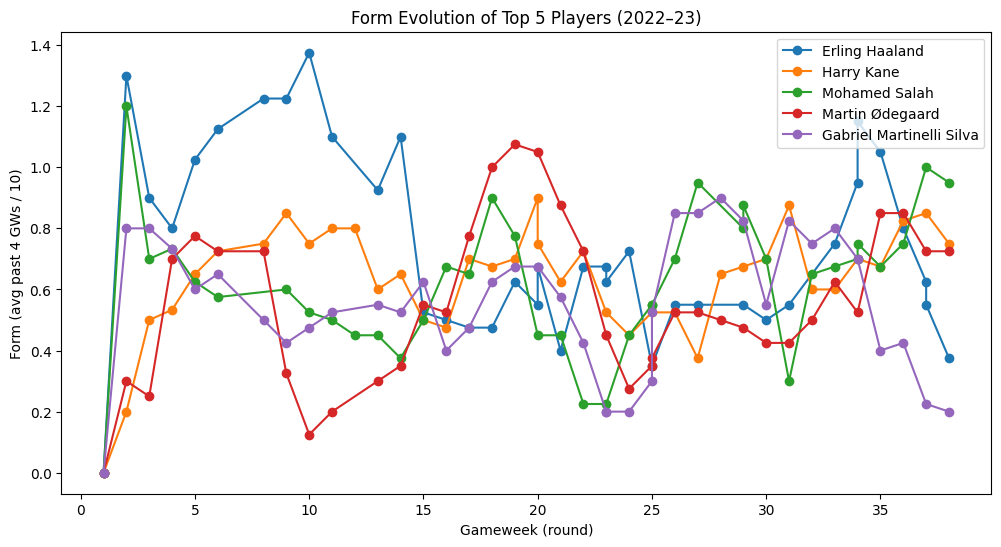

In [17]:
top_names = top5_form['name'].tolist()
evolution = season_22[season_22['name'].isin(top_names)]

plt.figure(figsize=(12,6))
for player in top_names:
    temp = evolution[evolution['name'] == player]
    plt.plot(temp['GW'], temp['form'], marker='o', label=player)

plt.title('Form Evolution of Top 5 Players (2022–23)')
plt.xlabel('Gameweek (round)')
plt.ylabel('Form (avg past 4 GWs / 10)')
plt.legend()
plt.show()


In [18]:
df_clean.head(1000)

,season_x,name,position,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,...,penalties_saved,red_cards,saves,selected,total_points,value,was_home,yellow_cards,GW,form
19852,2020-21,Aaron Connolly,3,0,0,-3,0,78,7,2,...,0,0,0,32205,1,55,1,0,1,0.000000
20277,2020-21,Aaron Connolly,3,0,2,27,1,78,16,0,...,0,0,0,35030,8,55,0,0,2,0.100000
20816,2020-21,Aaron Connolly,3,0,0,2,0,78,19,2,...,0,0,0,55356,2,55,1,0,3,0.450000
21370,2020-21,Aaron Connolly,3,0,0,7,0,78,32,3,...,0,0,0,55125,2,55,0,0,4,0.366667
21932,2020-21,Aaron Connolly,3,1,0,13,0,78,40,0,...,0,0,0,46774,4,55,0,0,5,0.325000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24491,2020-21,Abdoulaye Doucouré,2,0,2,43,0,512,81,2,...,0,0,0,77615,9,53,0,0,9,0.125000
25092,2020-21,Abdoulaye Doucouré,2,0,0,8,0,512,93,1,...,0,0,0,88271,2,53,1,0,10,0.300000
25677,2020-21,Abdoulaye Doucouré,2,0,0,16,0,512,101,1,...,0,0,0,87457,2,53,0,0,11,0.325000
26238,2020-21,Abdoulaye Doucouré,2,0,0,3,1,512,111,0,...,0,0,0,82413,2,53,1,1,12,0.350000


In [19]:
df_clean.head()

,season_x,name,position,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,...,penalties_saved,red_cards,saves,selected,total_points,value,was_home,yellow_cards,GW,form
19852,2020-21,Aaron Connolly,3,0,0,-3,0,78,7,2,...,0,0,0,32205,1,55,1,0,1,0.000000
20277,2020-21,Aaron Connolly,3,0,2,27,1,78,16,0,...,0,0,0,35030,8,55,0,0,2,0.100000
20816,2020-21,Aaron Connolly,3,0,0,2,0,78,19,2,...,0,0,0,55356,2,55,1,0,3,0.450000
21370,2020-21,Aaron Connolly,3,0,0,7,0,78,32,3,...,0,0,0,55125,2,55,0,0,4,0.366667
21932,2020-21,Aaron Connolly,3,1,0,13,0,78,40,0,...,0,0,0,46774,4,55,0,0,5,0.325000


In [20]:
df_clean.head(5)[["season_x","element","name","GW","total_points"]]

,season_x,element,name,GW,total_points
19852,2020-21,78,Aaron Connolly,1,1
20277,2020-21,78,Aaron Connolly,2,8
20816,2020-21,78,Aaron Connolly,3,2
21370,2020-21,78,Aaron Connolly,4,2
21932,2020-21,78,Aaron Connolly,5,4


## **Feature Selection**

We'll select relevant features that can help predict player performance (total_points).

In [21]:
# Display all features (columns) in df_clean
print("All features in df_clean:")
print("=" * 50)
print(df_clean.columns.tolist())
print("\n" + "=" * 50)
print(f"Total number of features: {len(df_clean.columns)}")
print("\n" + "=" * 50)
print("\nData types of each feature:")
print(df_clean.dtypes)

All features in df_clean:
['season_x', 'name', 'position', 'assists', 'bonus', 'bps', 'clean_sheets', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'minutes', 'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'selected', 'total_points', 'value', 'was_home', 'yellow_cards', 'GW', 'form']

Total number of features: 27


Data types of each feature:
season_x             object
name                 object
position              int64
assists               int64
bonus                 int64
bps                   int64
clean_sheets          int64
element               int64
fixture               int64
goals_conceded        int64
goals_scored          int64
ict_index           float64
minutes               int64
opponent_team         int64
opp_team_name        object
own_goals             int64
penalties_missed      int64
penalties_saved       int64
red_cards             int64
saves                 int64
selected   

## **Define Features and Target**

**Features (X):** We select relevant statistics that influence player performance:
- Position (encoded)
- Minutes played
- Goals scored
- Assists
- Clean sheets
- Goals conceded
- Bonus points
- BPS (Bonus Points System)
- ICT Index (Influence, Creativity, Threat combined)
- Creativity, Influence, Threat (individual components)
- Was home (playing at home vs away)
- Value (player cost)

**Target (y):** total_points - the Fantasy Premier League points the player earned in that gameweek.

In [22]:
# Select features for the model
# Separate categorical and numerical features
categorical_features = ['position', 'was_home']
numerical_features = [
    'minutes', 'goals_scored', 'assists', 
    'clean_sheets', 'goals_conceded', 'bonus', 'bps', 
    'ict_index', 'value', 'form',
    'saves', 'penalties_saved', 'penalties_missed',
    'yellow_cards', 'red_cards', 'own_goals'
]

# All features combined
feature_columns = categorical_features + numerical_features

# Feature and target
X = df_clean[feature_columns]
y = df_clean['total_points']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")
print(f"\nTarget statistics:\n{y.describe()}")

Features shape: (96169, 18)
Target shape: (96169,)

Categorical features: ['position', 'was_home']
Numerical features: ['minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'bonus', 'bps', 'ict_index', 'value', 'form', 'saves', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'own_goals']

Target statistics:
count    96169.000000
mean         1.379270
std          2.542535
min         -7.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         29.000000
Name: total_points, dtype: float64


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train data shape:", X_train.shape, "Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

Train data shape: (76935, 18) Train labels shape: (76935,)
Test data shape: (19234, 18) Test labels shape: (19234,)


# **Data Scaling and Splitting**

1. **Split into training and testing sets FIRST** (to prevent data leakage)
2. **Scale ONLY numerical features** (categorical features should remain unscaled)

In [24]:
scaler = StandardScaler()

# Extract categorical and numerical features from train/test sets
X_train_cat = X_train[categorical_features]
X_train_num = X_train[numerical_features]

X_test_cat = X_test[categorical_features]
X_test_num = X_test[numerical_features]

# Scale only numerical features
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Combine categorical (unscaled) with numerical (scaled)
import numpy as np
X_train_scaled = np.concatenate([X_train_cat.values, X_train_num_scaled], axis=1)
X_test_scaled = np.concatenate([X_test_cat.values, X_test_num_scaled], axis=1)

print(X_train_scaled[:5])

[[ 0.          0.         -0.8008632  -0.19592763 -0.18813264 -0.34530222
  -0.51038607 -0.22113549 -0.61688832 -0.564342   -0.58393045 -0.73068985
  -0.15638244 -0.02650253 -0.03246454 -0.23832635 -0.040179   -0.04066782]
 [ 2.          1.         -0.8008632  -0.19592763 -0.18813264 -0.34530222
  -0.51038607 -0.22113549 -0.61688832 -0.564342   -0.50458345 -0.73068985
  -0.15638244 -0.02650253 -0.03246454 -0.23832635 -0.040179   -0.04066782]
 [ 0.          0.         -0.8008632  -0.19592763 -0.18813264 -0.34530222
  -0.51038607 -0.22113549 -0.61688832 -0.564342   -0.58393045  0.49125414
  -0.15638244 -0.02650253 -0.03246454 -0.23832635 -0.040179   -0.04066782]
 [ 2.          0.          1.21873632 -0.19592763 -0.18813264 -0.34530222
   2.58081935 -0.22113549  0.39656673 -0.564342   -0.34588943 -0.32337519
  -0.15638244 -0.02650253 -0.03246454 -0.23832635 -0.040179   -0.04066782]
 [ 3.          1.          1.41577042 -0.19592763 -0.18813264  2.89601382
  -0.51038607 -0.22113549 -0.11016

In [25]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear')  # Linear for regression
])

2025-10-19 21:07:40.393528: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## **Model Summary**

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile the model for regression
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

print("Model compiled successfully!")

Model compiled successfully!


# **Train the FFNN Model**

We'll train the model with:
- **30 epochs:** Number of complete passes through the training data
- **Batch size of 32:** Number of samples processed before updating weights
- **Validation split of 20%:** 20% of training data used for validation
- **Early stopping:** Stops training if validation loss doesn't improve for 5 epochs

In [28]:
# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.2445 - mae: 0.4277 - mse: 1.2445 - val_loss: 0.0733 - val_mae: 0.1255 - val_mse: 0.0733
Epoch 2/30
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0694 - mae: 0.1305 - mse: 0.0694 - val_loss: 0.0654 - val_mae: 0.1328 - val_mse: 0.0654
Epoch 3/30
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0469 - mae: 0.0998 - mse: 0.0469 - val_loss: 0.0345 - val_mae: 0.0802 - val_mse: 0.0345
Epoch 4/30
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0422 - mae: 0.0899 - mse: 0.0422 - val_loss: 0.0478 - val_mae: 0.1000 - val_mse: 0.0478
Epoch 5/30
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0345 - mae: 0.0779 - mse: 0.0345 - val_loss: 0.0452 - val_mae: 0.0934 - val_mse: 0.0452
Epoch 6/30
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0308 - mae: 0.0711 - mse: 0.0308 - val_loss: 0.0332 - val_mae: 0.0745 - val_mse: 0.0332
Epoch 7/30
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0277 - mae: 0.0656 - mse

# **Visualize Training Progress**

Let's plot the training and validation metrics to see how the model learned over time.

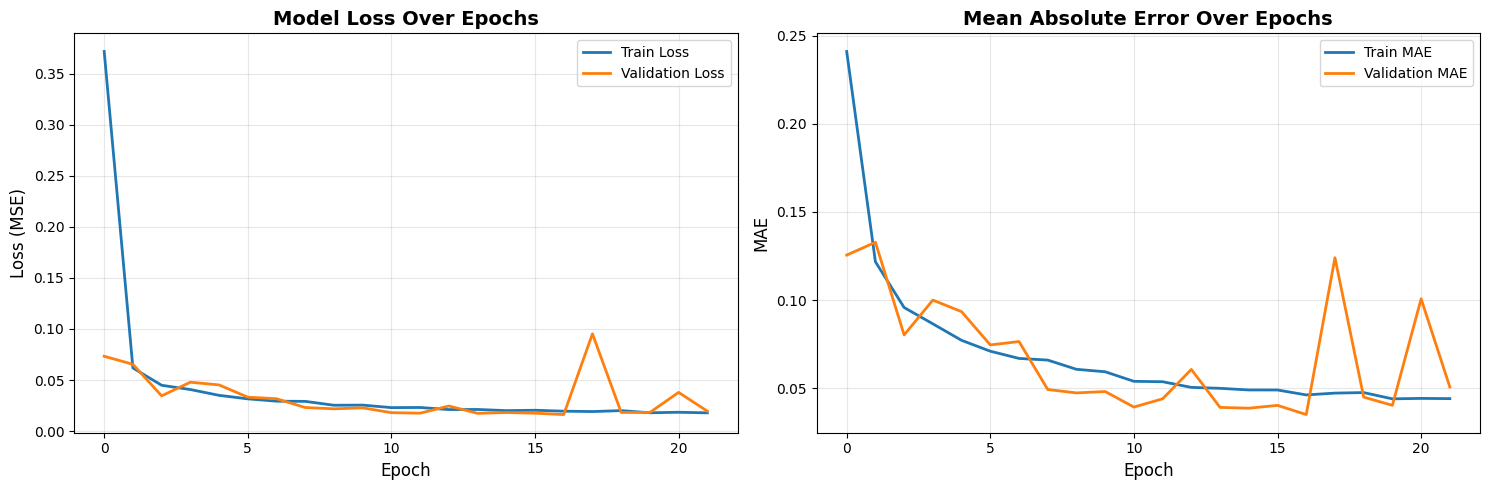

In [29]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Mean Absolute Error Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **Evaluate Model on Test Set**

Now let's test our model on unseen data to evaluate its performance.

In [30]:
# Evaluate on test set
test_loss, test_mae, test_mse = model.evaluate(X_test_scaled, y_test, verbose=0)

print("=" * 50)
print("MODEL PERFORMANCE ON TEST SET")
print("=" * 50)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {np.sqrt(test_mse):.4f}")
print("=" * 50)

MODEL PERFORMANCE ON TEST SET
Test Loss (MSE): 0.0159
Test MAE: 0.0346
Test MSE: 0.0159
Test RMSE: 0.1260
